## Anisotropic heterogeneous heat equation

This tutorial aims at illustrating the use of the Partitioned Finite Element Method (PFEM)(Cardo-Ribeoro et al, 2018) to discretize a port-Hamiltonian system (pHs) related to the simulation of the two-dimensional anisotropic heterogeneous heat equation. We specifically learn how to define and solve this problem with Scrimp. 

This notebook first defines the continuous problem by using a specific class of Scrimp related to the heat equation in two dimensions. Then we tackle the discretization in space of the port-Hamiltonian system through the PFEM methodology. The discretization of the energy formulation leads to a pHDAE formulation. After time discretization, we perform a numerical simulation to obtain an approximation of the space-time solution. Finally a simple postprocessing is performed.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import Scrimp
from math import sin, pi
from Heat import Energy

/usr/local/lib/python3.8/dist-packages/Assimulo-trunk-py3.8-linux-x86_64.egg/assimulo/solvers/odepack.py:710: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  N.array([[0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.],  # 5th order
Could not find GLIMDA.


## Problem statement


We consider the two-dimensional heterogeneous anisotropic heat equation defined for all $t\ge 0$ as

$$
\begin{array}{ll} 
    \rho(\boldsymbol x)\, C_V(\boldsymbol x) \displaystyle \frac{\partial}{\partial t} T(t,\boldsymbol x) &=& \text{div}\Big(\overline{\overline \lambda}(\boldsymbol x)\cdot\textbf{grad} \ T(t,\boldsymbol x)\Big), \quad \boldsymbol x \in \Omega, \\
    T(t,\boldsymbol x) & = & v_{\partial}(t,\boldsymbol x) ,      \quad \boldsymbol x \in \partial \Omega, \\ 
    T(0, \boldsymbol x)             & = & T_0(x), \quad \boldsymbol x \in \Omega, t=0 \\
\end{array}
$$

with $\Omega \subset \mathbb{R}^2$ an open bounded spatial domain with Lipschitz-continuous boundary $\delta \Omega$. $v_{\partial}(t,\boldsymbol x)$ represents the boundary control function on the temperature.

$T(t,\boldsymbol x)$ denotes the temperature at point $\boldsymbol x \in \Omega $ and time $t$. $\rho \in L^{\infty}(\Omega)$ (positive and bounded from below) denotes the mass density, $\overline{\overline \lambda} \in L^{\infty}(\Omega)^{2\times 2}$ (symmetric and coercive) the thermal conductivity. In the following $\Omega$ is assumed to be of rectangular shape.

## Port-Hamiltonian formulation 

We refer to <a href="https://www.sciencedirect.com/science/article/pii/S2405896319303040">Serhani et al, 2019a</a> and <a href="https://www.sciencedirect.com/science/article/pii/S2405896319303052">Serhani et al, 2019b</a>  for the modeling and discretization of various port Hamiltonian formulations of this problem. The authors consider Lyapunov functional, entropy or energy as Hamiltonian, respectively. 

We will consider the PFEM discretization of the energy functional formulation which will lead to a pHDAE system. Our goal in this tutorial is to show how a pHDAE system can be formulated and solved within Scrimp. 


We introduce the flow variables as

$$
\boldsymbol f_q = - \textbf{grad} \ \frac{u}{C_V}, \quad 
f_u = {\partial_t} u,
$$ 

and the effort variables as

$$
\boldsymbol e_q = - \textbf{J}, \quad 
e_u = \frac{u}{C_V},
$$ 

respectively, with 
$
\textbf{J} = -\overline{\overline \lambda}(\boldsymbol x)\cdot\textbf{grad} \ T.
$
The Hamiltonian can be defined as

$$
\mathcal{H} = \frac{1}{2} \int_{\Omega} \rho(\boldsymbol x) \displaystyle \frac{u^2}{C_V} dx.
$$

The infinite-dimensional port-Hamiltonian system can then be written as

\begin{eqnarray*}
\partial_t \left \lbrack 
\begin{array}{c}
\rho  f_u \\
\boldsymbol f_q 
\end{array}
\right \rbrack 
&=& 
\left \lbrack 
\begin{array}{cc}
0              & -{div} \\
-\textbf{grad} & 0 \\
\end{array}
\right \rbrack
\left \lbrack
\begin{array}{c}
e_u \\
\boldsymbol e_q 
\end{array}
\right \rbrack.
\end{eqnarray*}

As particular choice of boundary control function, we choose the Dirichlet trace of $e_u$, i.e., the temperature due to the Dulong-Petit's law.

## Setup

We initialize here the Python object related to the energy formulation of the Heat_2D class of Scrimp. This object will be used throughout this tutorial. 

In [2]:
H = Energy()

### Constants

We define the constants related to the definition of the rectangular domain $\Omega$. The coordinates of the bottom left ($x_0, y_0$) and the top right ($x_L, y_L$) corners of the rectangle are required. 

In [3]:
x0, xL, y0, yL = 0., 2., 0., 1.

We then define the time interval related to the time discretization. $t_i, t_f$ denote the values of the initial and final times respectively. 

In [4]:
ti, tf  = 0., 5.

We provide the time step for the time discretization of the pHDAE system.

In [5]:
dt = 1.e-3

### FEniCS expressions definition

For the finite element discretization of the spatial port-Hamiltonian formulation, the FEniCS library is used in the Heat_2D class of Scrimp. Hence to properly use FEniCS expression definition, we provide the definition of the different variables in C++ code given in strings. We first specify the mass density as a function depending on the space coordinates. Hence in this expression, x[0] corresponds to the first spatial variable and x[1] to the second one, respectively.

In [6]:
rho    = 'x[0]*(xL-x[0]) + x[1]*(yL-x[1]) + 2'

Then we specify the thermal conductivity tensor. Three components are only required due to the symmetry property of this tensor. 

In [7]:
Lambda11 = '5. + x[0]*x[1]'
Lambda12 = '(x[0]-x[1])*(x[0]-x[1])'
Lambda22 = '3.+x[1]/(x[0]+1)'

We finally specify the isochoric heat capacity $C_V$. Here a constant value is used on $\Omega$.

In [8]:
CV      = '3.'

We specify the initial conditions of the problem related to the temperature and to the flow and effort variables. The temperature follows a Gaussian behaviour for which we specify related parameters.

In [9]:
ampl, sX, sY, X0, Y0    = 1000, xL/6, yL/6, xL/2, yL/2 
au_0 = '3000'
eu_0 = ' ampl * exp(- pow( (x[0]-X0)/sX, 2) - pow( (x[1]-Y0)/sY, 2) ) + 1000'

We define the spatial part of the boundary control function next.

In [10]:
Ub_sp0  = ''' 
           ( abs(x[0]) <= DOLFIN_EPS ?  1. * (yL-x[1])*x[1] : 0 )
        + ( abs(x[1])  <= DOLFIN_EPS ?  1. * (xL-x[0])*x[0] : 0 )            
        + ( abs(xL - x[0]) <= DOLFIN_EPS ?  -15. * (yL-x[1])*x[1] : 0 )
        + ( abs(yL - x[1]) <= DOLFIN_EPS  ? 1. * (xL-x[0])*x[0] : 0 )      
        '''

We finally define the time-dependent part of the boundary control function as a pure Python function. The whole boundary control function is then defined as the product of the two quantities ($Ub_{sp0}$ and $Ub_{tm0}$, respectively). As a consequence, we note that the boundary control function $v_{\partial}$ is zero after two seconds.

In [11]:
def Ub_tm0(t):
    if t<=2:
        return 500 * sin(2 * pi * t) 
    else: return 0

## Problem at the continuous level

We are now able to completely define the problem at the continuous level. We start by specifying that the computational domain $\Omega$ is of rectangular shape. To define $\Omega$, we provide the coordinates of the left bottom and top right corners to the Heat_2D object.

In [12]:
H.Set_Rectangular_Domain(x0, xL, y0, yL);

----------------------------------------
Rectangular domain: OK
----------------------------------------


We then provide the time integration interval. 

In [13]:
H.Set_Initial_Final_Time(initial_time=ti, final_time=tf);

----------------------------------------
Initial/Final time: OK
----------------------------------------


We then provide the physical parameters related to the heat equation: the mass density, the thermal conductivity tensor, and the isochoric heat capacity, respectively.

In [14]:
H.Set_Physical_Parameters(rho=rho, Lambda11=Lambda11, Lambda12=Lambda12, Lambda22=Lambda22, CV=CV);

----------------------------------------
Physical parameters: OK
----------------------------------------


## Problem at the discrete level in space and time

We use the Partitioned Finite Element Method to discretize the infinite dimensional port-Hamiltonian system given above related to the energy functional. The structure preserving discretization of the infinite-dimensional port-Hamiltonian system with the PFEM method is described in detail in <a href="https://www.sciencedirect.com/science/article/pii/S2405896319303052">Serhani et al, 2019b</a>. Formally we obtain a pHDAE system of the following structure

\begin{eqnarray*}
\left \lbrack 
\begin{array}{ccc}
M_{\rho}  & 0 & 0 \\
0    & M & 0 \\
0    & 0   & M_{\partial} \\
\end{array}
\right \rbrack
\left \lbrack 
\begin{array}{c}
\underline  f_u              \\
\boldsymbol {\underline f_q} \\
\underline {-y_{\partial}}
\end{array}
\right \rbrack 
&=& 
\left \lbrack 
\begin{array}{ccc}
0  & D & B \\
-D^T & 0 & 0 \\
-B^T & 0 & 0 \\
\end{array}
\right \rbrack
\left \lbrack
\begin{array}{c}
\underline e_u \\
\underline {\boldsymbol e_q} \\
\underline {v_{\partial}} \\
\end{array}
\right \rbrack.
\end{eqnarray*} 

We start by generating the computational mesh. The parameter rfn_num corresponds to a global mesh refinement parameter. 

In [15]:
H.Set_Gmsh_Mesh(xmlfile='rectangle.xml', rfn_num=1);

----------------------------------------
Mesh: hmax= 0.336 Nv= 57
Mesh: OK
----------------------------------------


To perform the semi-discretization in space, we must first specify the conforming finite element approximation spaces to be used. Concerning the energy variables related to $f_q$, we select the Raviart-Thomas finite element family known as $RT_k$ consisting of vector functions with a continuous normal component across the interfaces between the elements of a mesh. For the energy variables associated with $f_u$ and the boundary variables, we choose the classical $P_k$ finite element approximation. The given combination of parameters rt_order=0, p_order=1, b_order=1 corresponds to the $RT_0 P_1 P_1$ case. 

In [16]:
H.Set_Finite_Element_Spaces(family_scalar='P', family_Vector='RT', family_boundary='P', rs=1, rV=0, rb=1);

----------------------------------------
VV= RT_0 ,	 Vs= P_1 ,	 Vb= P_1
NV= 144 ,	 Ns= 57 ,	 Nb= 24
DOFsys= 201
FE spaces: OK
----------------------------------------


We then perform the semi-discretization in space of the weak formulation with the PFEM method. At the end of this stage, the complete formulation of the pHDAE is obtained. The different matrices related to the pHDAE system are constructed in the Assembly method of the Heat_2D class of Scrimp and are directly accessible through the object of the Heat_2D class. The finite element assembly relies on the variational formulation of PFEM and exploits the level of abstraction provided by the unified form language (UFL) used in FEniCS, leading to a code that is close to the mathematical formulation.

In [17]:
H.Assembly();

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


/usr/lib/python3/dist-packages/FIAT/check_format_variant.py:9: DeprecationWarning: Variant of Raviart Thomas element will change from point evaluation to integral evaluation. You should project into variant="integral"
  warnings.warn('Variant of ' + element + ' element will change from point evaluation to integral evaluation.'


Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
----------------------------------------
Assembly: OK
----------------------------------------


To perform the time integration of the pHDAE, we first need to create and interpolate the initial data and the boundary control function on the appropriate finite element spaces. 

In [18]:
H.Set_Initial_Data(au_0=au_0, eu_0=eu_0, ampl=ampl, sX=sX, sY=sY, X0=X0, Y0=Y0);
H.Project_Initial_Data(); 

/home/andrea/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


----------------------------------------
Initial data: OK
----------------------------------------
----------------------------------------
Project initial data: OK
----------------------------------------


In [19]:
H.Set_Boundary_Control(Ub_tm0= Ub_tm0, Ub_sp0=Ub_sp0, Ub_tm1=lambda t :0, Ub_sp1='1000');
H.Project_Boundary_Control();

/home/andrea/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


----------------------------------------
Boundary control: OK
----------------------------------------
----------------------------------------
Project boundary control: OK
----------------------------------------


Then we specify the uniform time step related to the time discretization. 

In [20]:
H.Set_Time_Setting(dt);

----------------------------------------
dt = 0.001
Time setting: OK
----------------------------------------


/home/andrea/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Numerical approximation of the space-time solution

Now we perform the time integration of the resulting pHDAE system and deduce the behaviour of the energy variables, the Hamiltonian with respect to the time and space variables, respectively. The underlying solution algorithm is given in Algorithm 2 of Section 4.4 (Serhani, 2020). 

In [21]:
H.Set_Formulation('div')
au, fU, fsig, eu, eU, esig, Hamiltonian = H.Integration_DAE();

----------------------------------------
Formulation div-div: OK
----------------------------------------
Calling FFC just-in-time (JIT) compiler, this may take some time.


/home/andrea/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Time integration: |################################################## 100%|Calling FFC just-in-time (JIT) compiler, this may take some time.


## Post-processing

We represent the two-dimensional mesh with corresponding degrees of freedom for each variable. 

/home/andrea/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


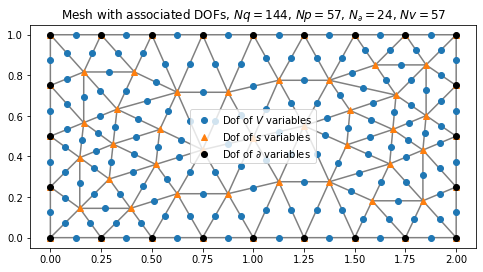

In [22]:
H.notebook = True
H.Plot_Mesh_with_DOFs()    

As illustration, we plot the Hamiltonian function versus time. As expected, the Hamiltonian function is constant after two seconds since the boundary control function is then equal to zero.

/home/andrea/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


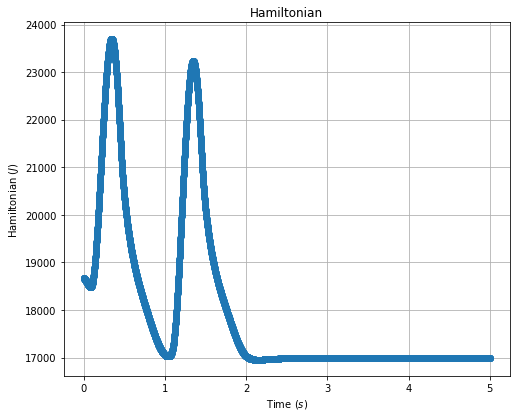

In [23]:
H.Plot_Hamiltonian(H.tspan, Hamiltonian, marker='o')


/home/andrea/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


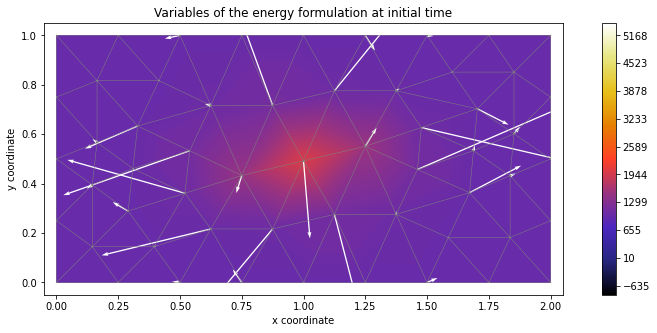

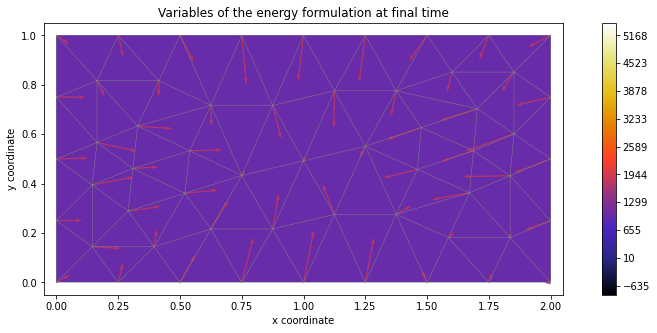

In [25]:
H.Contour_Quiver(var_scalar=eu, var_Vect=eU, with_mesh=True, t=ti,\
                title="Variables of the energy formulation at initial time",\
                margin=0.05, save=False, figsize=(14,5))
H.Contour_Quiver(var_scalar=eu, var_Vect=eU, with_mesh=True, t=tf,\
                title="Variables of the energy formulation at final time",\
                margin=0.05, save=False, figsize=(14,5))
    

## Further information


- <a href="https://www.sciencedirect.com/science/article/pii/S2405896318303252">"Structure-preserving Partitioned Finite Element Method for the 2D wave equation"</a> by F. L. Cardoso-Ribeiro, D. Matignon, L. Lefèvre. In IFAC-PapersOnLine, 51 (3), 119–124, 2018.


- <a href="https://www.sciencedirect.com/science/article/pii/S2405896319303040">"Anisotropic heterogeneous n-D heat equation with boundary control and observation: I. Modeling as port-Hamiltonian system"</a> by A. Serhani, D. Matignon and G. Haine, IFAC-PapersOnLine, 
52 (7), 51-56, 2019.


- <a href="https://www.sciencedirect.com/science/article/pii/S2405896319303052">"Anisotropic heterogeneous n-D heat equation with boundary control and observation: II. Structure-preserving discretization"</a> by A. Serhani, D. Matignon and G. Haine, IFAC-PapersOnLine, 
52 (7), 57-62, 2019.


- <a href="https://link.springer.com/chapter/10.1007%2F978-3-030-26980-7_57">"A Partitioned Finite Element Method for the Structure-Preserving Discretization of Damped Infinite-Dimensional Port-Hamiltonian Systems with Boundary Control"</a> by A. Serhani, D. Matignon, G. Haine. Geometric Science of Information, editors F. Nielsen and F. Barbaresco, Lecture Notes in Computer Science, Springer, volume 11712, 549-558, 2019.


- "Systèmes couplés d'EDPs, vus comme des systèmes Hamiltoniens à ports avec dissipation : Analyse théorique et simulation numérique", A. Serhani, PhD thesis, University of Toulouse, ISAE-SUPAERO, France, 2020. 
